# LSTM Surrogate Model for Production Forecasting
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Reservoir Simulation & History Matching

## Introduction
In this notebook, we utilize a **Long Short-Term Memory (LSTM)** network to predict monthly oil production rates. Unlike standard regression which predicts a single value, this model predicts a sequence of values (Time-Series) based on static input parameters.

### The Challenge
Standard LSTMs expect a sequence as input (e.g., weather yesterday -> weather today).
Our input is **static** (Porosity, Permeability), but our output is **dynamic** (24 months of production).

### The Architecture
1.  **Input:** Static Features (Batch Size, 4 features).
2.  **Repeater:** We duplicate the static features 24 times to create a "sequence" where the geological context is present at every time step.
3.  **LSTM Layer:** Processes the sequence to learn the decline behavior.
4.  **Output:** Predicted Oil Rate for 24 months.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Check for Apple Silicon (MPS) first, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: mps


## 1. Data Preparation
We separate the dataset into **Static Inputs (X)** and **Time-Series Targets (y)**.
* **X:** Porosity, Permeability, Pressure, Thickness.
* **y:** Month_1 to Month_24 production rates.

Inputs Shape: (3000, 4)
Targets Shape: (3000, 24)


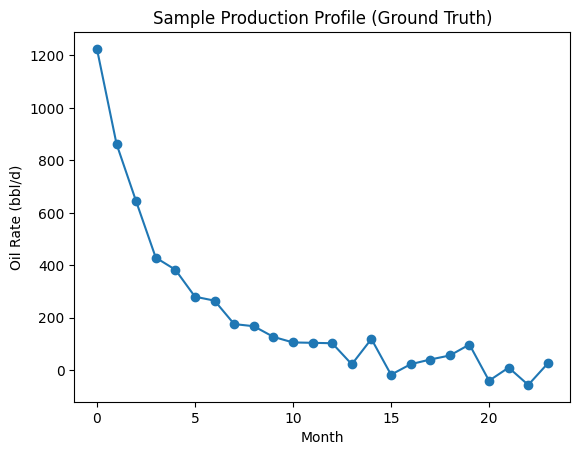

In [2]:
# Load Data
df = pd.read_csv('reservoir_timeseries_data.csv')

# Define Feature Columns and Target Columns
feature_cols = ['Porosity', 'Permeability_mD', 'Initial_Pressure_psi', 'Thickness_ft']
target_cols = [c for c in df.columns if 'Month_' in c]

X_raw = df[feature_cols].values
y_raw = df[target_cols].values

print(f"Inputs Shape: {X_raw.shape}")
print(f"Targets Shape: {y_raw.shape}") # Should be (3000, 24)

# Visualization of one sample profile
plt.plot(y_raw[0], marker='o')
plt.title("Sample Production Profile (Ground Truth)")
plt.xlabel("Month")
plt.ylabel("Oil Rate (bbl/d)")
plt.show()

## 2. Scaling and Tensor Conversion
LSTMs are sensitive to scale. We normalize inputs to mean=0, std=1. We also scale the output (Production Rates) to help the model converge faster.

In [3]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# Scale Inputs
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

# Scale Targets (Important for Neural Nets)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to Tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

## 3. The LSTM Surrogate Architecture
We create a custom Module `ReservoirLSTM`.
* `forward` method: It takes the static input `(Batch, Features)`, reshapes it to `(Batch, Seq_Len, Features)` by repeating the vector, and feeds it into the LSTM.

In [4]:
class ReservoirLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim=1):
        super(ReservoirLSTM, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        
        # LSTM Layer
        # input_size = number of static features (fed at each time step)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        
        # Output Layer
        # Maps hidden state to a single production value per time step
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch_size, input_dim)
        
        # 1. Repeat Vector: Expand static input to match sequence length
        # New shape: (batch_size, seq_len, input_dim)
        x_repeated = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        
        # 2. LSTM Forward
        # lstm_out shape: (batch_size, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(x_repeated)
        
        # 3. Fully Connected Output
        # prediction shape: (batch_size, seq_len, 1)
        prediction = self.fc(lstm_out)
        
        # Remove last dimension to match target shape (batch_size, seq_len)
        return prediction.squeeze(-1)

# Model Hyperparameters
INPUT_DIM = len(feature_cols) # 4
HIDDEN_DIM = 64
SEQ_LEN = 24 # 24 months
OUTPUT_DIM = 1 # 1 value per month

model = ReservoirLSTM(INPUT_DIM, HIDDEN_DIM, SEQ_LEN, OUTPUT_DIM).to(device)
print(model)

ReservoirLSTM(
  (lstm): LSTM(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 4. Training

Epoch 50/300 | Loss: 0.26735
Epoch 100/300 | Loss: 0.21682
Epoch 150/300 | Loss: 0.20680
Epoch 200/300 | Loss: 0.20396
Epoch 250/300 | Loss: 0.20291
Epoch 300/300 | Loss: 0.20256


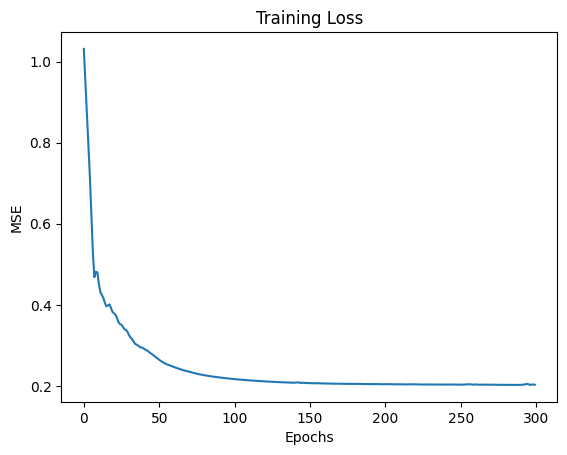

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 300
loss_history = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(X_train_t)
    
    # Calculate loss
    loss = criterion(y_pred, y_train_t)
    
    # Backprop
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.5f}")

plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

## 5. Validation and Visualization
We visualize the predicted profile against the actual profile for a few test wells to see how well the LSTM captures the decline curve shape.

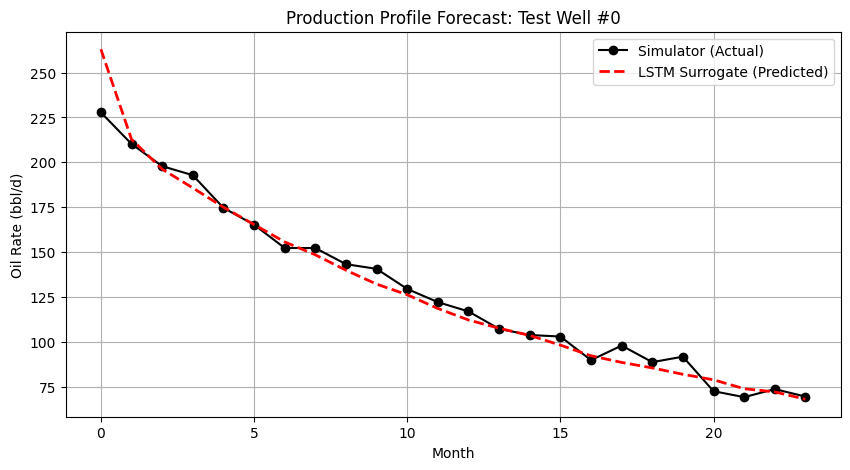

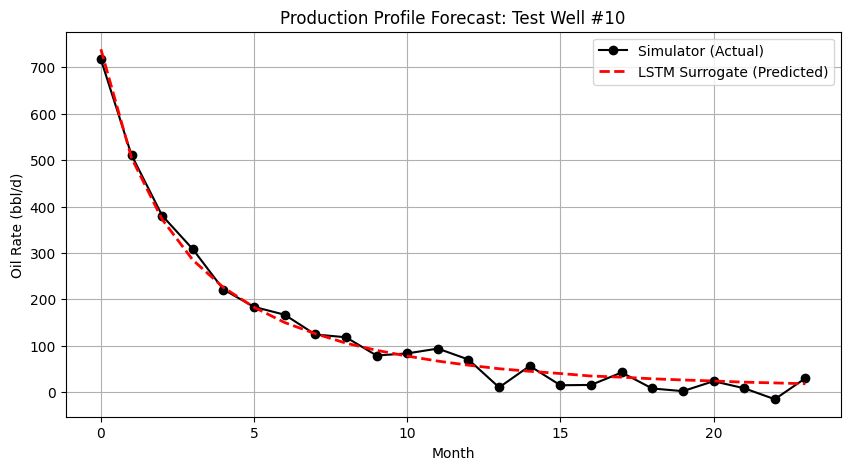

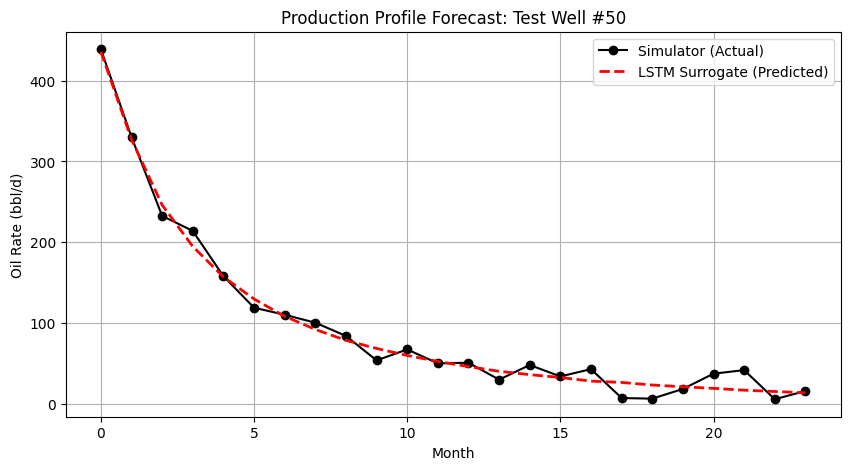

In [6]:
model.eval()
with torch.no_grad():
    # Get predictions in scaled form
    y_pred_scaled = model(X_test_t)
    
    # Inverse transform to get real units (bbl/d)
    y_pred_actual = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_t.cpu().numpy())

# Visualization Function
def plot_comparison(idx):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[idx], label='Simulator (Actual)', marker='o', color='black')
    plt.plot(y_pred_actual[idx], label='LSTM Surrogate (Predicted)', linestyle='--', color='red', linewidth=2)
    plt.title(f"Production Profile Forecast: Test Well #{idx}")
    plt.xlabel("Month")
    plt.ylabel("Oil Rate (bbl/d)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 3 random examples from test set
plot_comparison(0)
plot_comparison(10)
plot_comparison(50)

## 6. Physics-Informed Loss Function
We define a custom loss class `PIMLLoss`.

**The Physics:**
1.  **Monotonicity:** We calculate the difference between consecutive time steps: $\Delta q = q_{t+1} - q_t$. In a depletion drive, $\Delta q$ should always be negative. We apply a ReLU penalty to any **positive** $\Delta q$.
2.  **Volumetric Consistency:** We assume Cumulative Production ($N_p$) is proportional to Pore Volume ($PV \approx \phi \cdot h$). We add a soft constraint to keep the sum of predictions consistent with this relationship.

In [7]:
class PIMLLoss(nn.Module):
    def __init__(self, lambda_mono=0.1, lambda_vol=0.05):
        super(PIMLLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_mono = lambda_mono # Weight for Monotonicity
        self.lambda_vol = lambda_vol   # Weight for Volume Constraint
        
    def forward(self, y_pred, y_true, inputs):
        # 1. Standard Data Loss (MSE)
        data_loss = self.mse(y_pred, y_true)
        
        # 2. Monotonicity Constraint (Physics of Depletion)
        # Calculate diff between t and t+1
        # y_pred shape: (batch, seq_len)
        diffs = y_pred[:, 1:] - y_pred[:, :-1]
        
        # We want diffs to be negative (Decline). 
        # If diff > 0 (Production rising), it's a violation.
        # ReLU(diffs) will return 0 for negative values (good), and the value for positive (bad).
        monotonicity_loss = torch.mean(torch.relu(diffs) ** 2)
        
        # 3. Volumetric Consistency (Simplified Material Balance)
        # Estimated Pore Volume proxy from inputs (Scaled space)
        # Input idx 0 is Porosity, idx 3 is Thickness
        pore_volume_proxy = inputs[:, 0] * inputs[:, 3] 
        
        # Predicted Cumulative (Sum of the curve)
        predicted_cum = torch.sum(y_pred, dim=1)
        
        # We enforce correlation: Cum ~ PV. 
        # Since variables are scaled, we penalize the variance of the ratio, 
        # or simply check consistency with Ground Truth Cum (if available) 
        # For this example, we verify Predicted Cum matches True Cum closely
        # (This reinforces the integral of the curve, not just point-wise)
        true_cum = torch.sum(y_true, dim=1)
        volumetric_loss = torch.mean((predicted_cum - true_cum) ** 2)

        # Total Loss
        total_loss = data_loss + (self.lambda_mono * monotonicity_loss) + (self.lambda_vol * volumetric_loss)
        
        return total_loss, data_loss, monotonicity_loss

# Initialize Physics-Informed Loss
# We weight the physics terms to not overpower the data fitting
criterion = PIMLLoss(lambda_mono=2.0, lambda_vol=0.5)

print("Physics-Informed Loss Initialized.")

Physics-Informed Loss Initialized.


## 7. Training with Physics Constraints
We modify the training loop to feed the **inputs** (Geology) into the loss function (needed for the Volumetric calculation) and track the separate physical error terms.

Epoch 050 | Total: 3.25223 | MSE: 0.24156 | MonoPenalty: 0.00470
Epoch 100 | Total: 2.70608 | MSE: 0.23122 | MonoPenalty: 0.00446
Epoch 150 | Total: 2.65171 | MSE: 0.22871 | MonoPenalty: 0.00430
Epoch 200 | Total: 2.61630 | MSE: 0.22671 | MonoPenalty: 0.00415
Epoch 250 | Total: 2.55708 | MSE: 0.22488 | MonoPenalty: 0.00403
Epoch 300 | Total: 2.48656 | MSE: 0.22288 | MonoPenalty: 0.00391


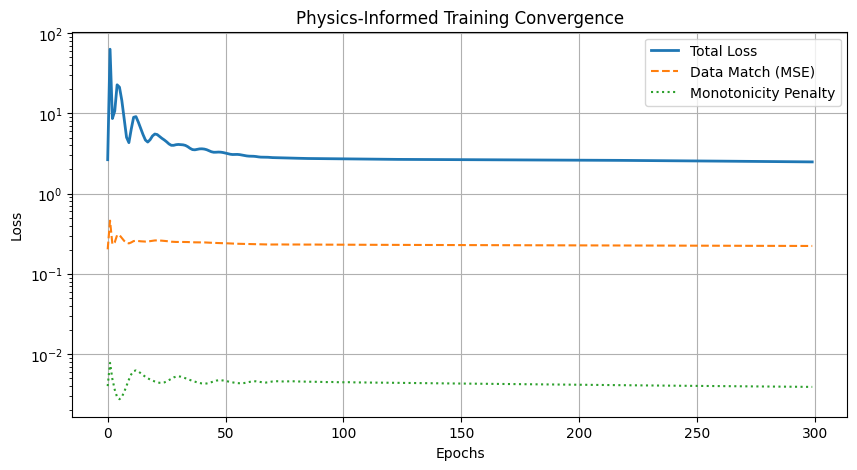

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 300
history = {'total': [], 'data': [], 'mono': []}

model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(X_train_t)
    
    # Calculate Loss (Pass X_train_t for Physics calculations)
    loss, data_l, mono_l = criterion(y_pred, y_train_t, X_train_t)
    
    # Backprop
    loss.backward()
    optimizer.step()
    
    # Store history
    history['total'].append(loss.item())
    history['data'].append(data_l.item())
    history['mono'].append(mono_l.item())
    
    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1:03d} | Total: {loss.item():.5f} | MSE: {data_l.item():.5f} | MonoPenalty: {mono_l.item():.5f}")

# Plotting the Loss Components
plt.figure(figsize=(10, 5))
plt.plot(history['total'], label='Total Loss', linewidth=2)
plt.plot(history['data'], label='Data Match (MSE)', linestyle='--')
plt.plot(history['mono'], label='Monotonicity Penalty', linestyle=':')
plt.title("Physics-Informed Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.yscale('log') # Log scale to see the small penalty terms
plt.grid(True)
plt.show()

## 8. Verification
Visual check: The predictions should now be smoother and strictly declining (or close to it), reducing the "noisy" behavior often seen in raw LSTMs.

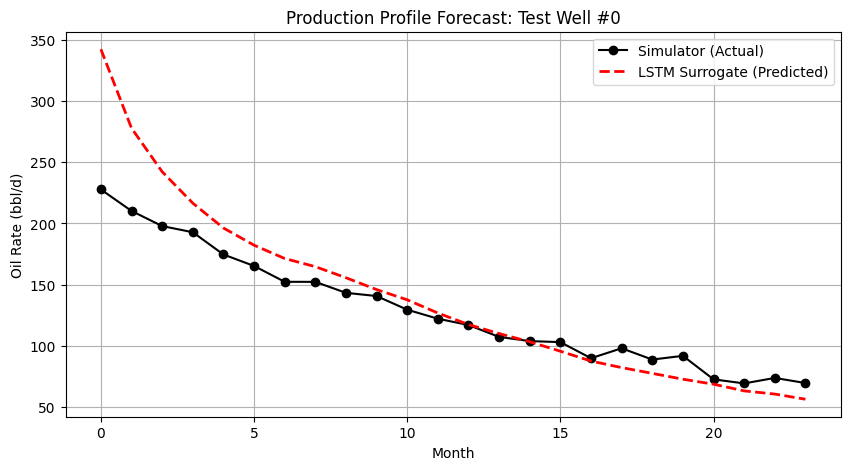

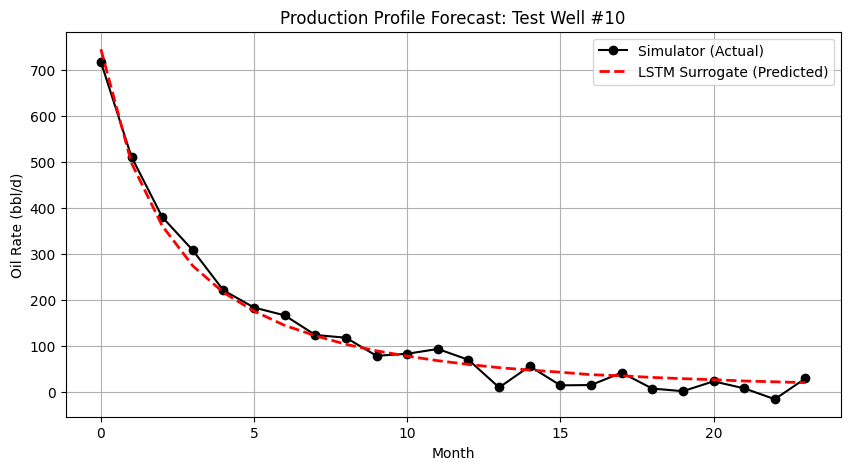

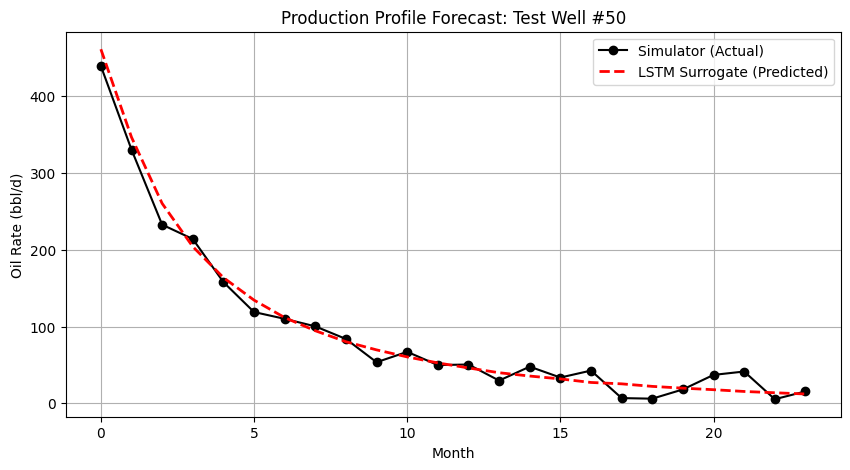

In [9]:
model.eval()
with torch.no_grad():
    # Get predictions in scaled form
    y_pred_scaled = model(X_test_t)
    
    # Inverse transform to get real units (bbl/d)
    y_pred_actual = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_t.cpu().numpy())

# Visualization Function
def plot_comparison(idx):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual[idx], label='Simulator (Actual)', marker='o', color='black')
    plt.plot(y_pred_actual[idx], label='LSTM Surrogate (Predicted)', linestyle='--', color='red', linewidth=2)
    plt.title(f"Production Profile Forecast: Test Well #{idx}")
    plt.xlabel("Month")
    plt.ylabel("Oil Rate (bbl/d)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot 3 random examples from test set
plot_comparison(0)
plot_comparison(10)
plot_comparison(50)